# Laboratorium 3

### Konfiguracja

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection([]))

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [183]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


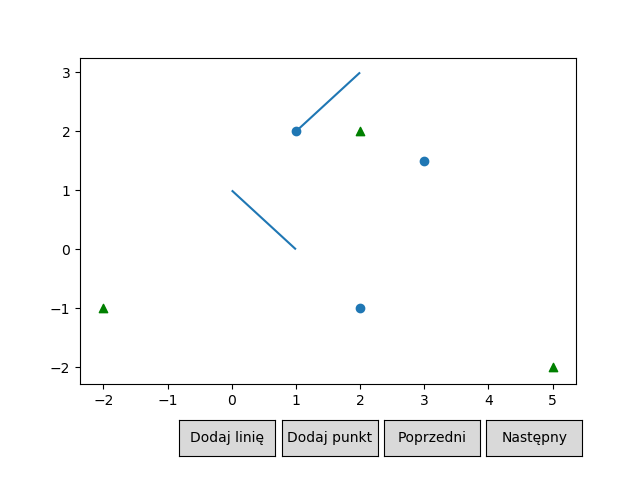

In [184]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]
plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))

plot.draw()


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


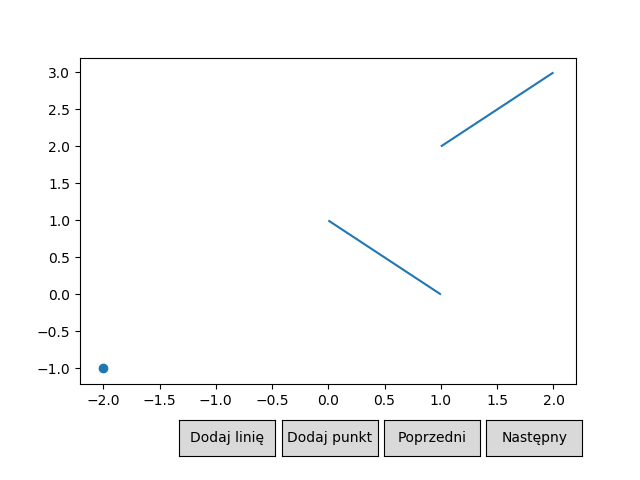

In [185]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    lol = file.read()
    
plot2 = Plot(json=lol)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


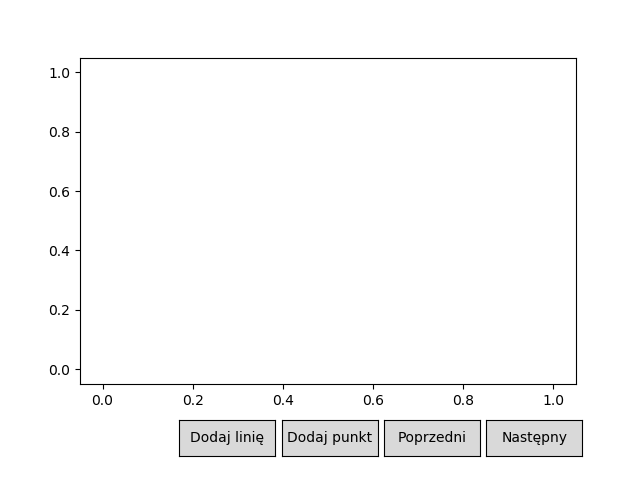

In [186]:
#Dodaj tu punkty i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


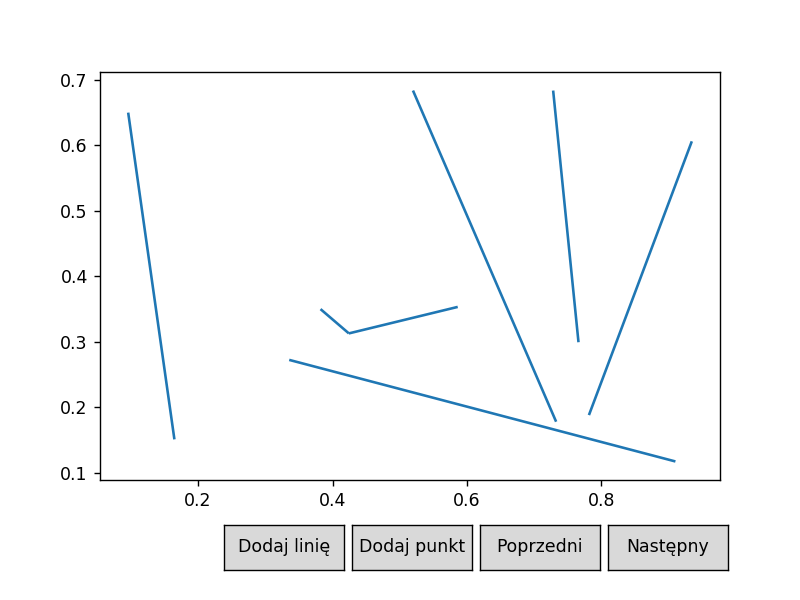

In [58]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

# Rozwiązanie

# Poniżej definicja klasy Line, której używam w swoim programie

In [187]:
from random import seed,random
import heapq
import bisect

class Point:
    def __init__(self,x,y):
        self.x=x
        self.y=y
        
    def __eq__(self,other):
        return isinstance(other,self.__class__) and self.x==other.x and self.y==other.y
    
    def __lt__(self,other):
        return self.x<other.x or (self.x==other.x and self.y<other.y)
    
    def __str__(self):
        return '('+str(self.x)+','+str(self.y)+')'
    
    def __hash__(self):
        return hash((self.x,self.y))

def det(a,b,c):
    return a.x*b.y + a.y*c.x + b.x*c.y - b.y*c.x - a.y*b.x - a.x*c.y

def orientation(x,line):
    c_det = det(line.s,line.e,x)
    if c_det>1e-7:
        return 1
    elif c_det<-1e-7:
        return -1
    else:
        return 0                    

class Line:
    def __init__(self,s,e):
        self.s=s
        self.e=e
        self.orientation=self.s
  
    def __eq__(self,other):
        return isinstance(other,self.__class__) and self.s==other.s and self.e==other.e
    def __lt__(self,other):
        c_orientation = None
        if self.orientation.x>=other.orientation.x:
            c_orientation = orientation(self.orientation, other)
        else:
            c_orientation = -orientation(other.orientation, self)
        return (c_orientation==1) or (c_orientation==0 and orientation(self.e,other)==1)

    def __str__(self):
        return 'Line segment from '+str(self.s)+ ' to ' +str(self.e)

# Rozwiązanie punktu 1

# Teraz umieszczam kod na generowanie własnych linii i linii losowych o współrzędnych z danego przedziału oraz wczytywanie i zapisywanie linii.

In [188]:
def generate_lines_from_file(file):              
    lines=[]
    with open(file, 'r') as file:
        lines = file.read()
    return lines

def save_lines_to_file(file,plot):
    with open(file, 'w') as file:
        file.write(plot.toJson())
        
def generate_your_lines_from_scene(plot):
    lines=[]
    points=set()                                 # to check if they don't meet at the ends
    scene=plot.get_added_lines()
    for i in range(len(scene)):
        for line in scene[i].lines:
            start=Point(round(line[0][0],10),round(line[0][1],10))
            end=Point(round(line[1][0],10),round(line[1][1],10))
            if start in points or end in points:                       # if lines meet at the ends, we omit one
                continue
            if start.x<end.x:
                lines.append(Line(start,end))
            else:
                lines.append(Line(end,start))
            points.add(start)
            points.add(end)
    return lines
    

def generate_random_lines():                    
    lines=[]
    points=set()                                # to check if they don't meet at the ends
    number=int(input("Enter the number of lines you want to generate randomly: "))
    l=int(input("Enter first bound of x and y: "))
    r=int(input("Enter second bound of x and y: "))
    seed()
    while(number>0):
        x1=l+random()*(r-l)
        x2=l+random()*(r-l)
        while(x2==x1):
            seed()
            x2=l+random()*(r-l)
        y1=l+random()*(r-l)
        y2=l+random()*(r-l)
        start=Point(round(x1,10),round(y1,10))
        end=Point(round(x2,10),round(y2,10))
        if start in points or end in points:
            continue
        if start.x<end.x:
            lines.append(Line(start,end))
        else:
            lines.append(Line(end,start))
        points.add(start)
        points.add(end)
        number -=1
    return lines

# Rozwiązanie punktu 2

# Wrzucam funkcje pomocnicze:

In [189]:
# checks if lines ab and cd intersects and returns intersection point
def intersect(line1,line2):
    r = (line1.e.x-line1.s.x, line1.e.y-line1.s.y)
    s = (line2.e.x-line2.s.x, line2.e.y-line2.s.y)
    
    rxs = r[0]*s[1] - r[1]*s[0] #if rxs = 0 then lines colinear
    
    if(rxs > 1e-7 or rxs < -1e-7):
        q_p = (line2.s.x - line1.s.x, line2.s.y - line1.s.y)
        t = (q_p[0]*s[1] - q_p[1]*s[0]) / rxs
        u = (q_p[0]*r[1] - q_p[1]*r[0]) / rxs
        
        if((t >= 0. and t<=1.) and (u >= 0. and u <= 1.)):
            return (round(line1.s.x + t*r[0], 10), round(line1.s.y + t*r[1], 10))
        else:
            return None
    else:
        return None

# print all lines
def printLines(lines):
    for i in range(len(lines)):
        print(lines[i])

# visualize all lines
def drawLines(lines):
    linesToDraw=[]
    for line in lines:
        linesToDraw.append([(line.s.x,line.s.y),(line.e.x,line.e.y)])
    return linesToDraw

def copy(lines):
    tmp=[]
    for line in lines:
        tmp.append(Line(line.s,line.e))
    return tmp

# Wrzucam implementację drzewa RB, zapożyczoną od użytkownika Charles Oliver Nutter oraz zmodyfikowaną przeze mnie na potrzeby zadania (link w pliku tekstowym z punktu 3):

In [190]:
# Written by Charles Oliver Nutter
# Modified for the purpose of Line Segments Intersection problem by Łukasz Jezapkowicz
# This is a RB-tree for lines
from math import sqrt

class Node:
    RED = True
    BLACK = False

    def __init__(self, line, color = RED):
        if not type(color) == bool:
            raise TypeError("Bad value for color parameter, expected True/False but given %s" % color)
        self.color = color
        self.line = line
        self.left = self.right = self.parent = NilNode.instance()

    def __str__(self, level = 0, indent = "   "):
        s = level * indent + str(self.line)
        if self.left:
            s = s + "\n" + self.left.__str__(level + 1, indent)
        if self.right:
            s = s + "\n" + self.right.__str__(level + 1, indent)
        return s

    def __nonzero__(self):
        return True

    def __bool__(self):
        return True


class NilNode(Node):
    __instance__ = None

    @classmethod
    def instance(self):
        if self.__instance__ is None:
            self.__instance__ = NilNode()
        return self.__instance__

    def __init__(self):
        self.color = Node.BLACK
        self.line = None
        self.left = self.right = self.parent = None

    def __nonzero__(self):
        return False

    def __bool__(self):
        return False

class RedBlackTree:
    def __init__(self):
        self.root = NilNode.instance()
        self.size = 0

    def __str__(self):
        return ("(root.size = %d)\n" % self.size)  + str(self.root)

    def add(self, line):
        self.insert(Node(line))

    def insert(self, x):
        self.__insert_helper(x)

        x.color = Node.RED
        while x != self.root and x.parent.color == Node.RED:
            if x.parent == x.parent.parent.left:
                y = x.parent.parent.right
                if y and y.color == Node.RED:
                    x.parent.color = Node.BLACK
                    y.color = Node.BLACK
                    x.parent.parent.color = Node.RED
                    x = x.parent.parent
                else:
                    if x == x.parent.right:
                        x = x.parent
                        self.__left_rotate(x)
                    x.parent.color = Node.BLACK
                    x.parent.parent.color = Node.RED
                    self.__right_rotate(x.parent.parent)
            else:
                y = x.parent.parent.left
                if y and y.color == Node.RED:
                    x.parent.color = Node.BLACK
                    y.color = Node.BLACK
                    x.parent.parent.color = Node.RED
                    x = x.parent.parent
                else:
                    if x == x.parent.left:
                        x = x.parent
                        self.__right_rotate(x)
                    x.parent.color = Node.BLACK
                    x.parent.parent.color = Node.RED
                    self.__left_rotate(x.parent.parent)
        self.root.color = Node.BLACK

    def delete(self, line):
        z=self.search(line)
        if not z.left or not z.right:
            y = z
        else:
            y = self.successor(line)
        if not y.left:
            x = y.right
        else:
            x = y.left
        x.parent = y.parent

        if not y.parent:
            self.root = x
        else:
            if y == y.parent.left:
                y.parent.left = x
            else:
                y.parent.right = x

        if y != z: z.line = y.line

        if y.color == Node.BLACK:
            self.__delete_fixup(x)

        self.size -= 1
        return y

    def successor(self, line):
        x=self.search(line)
        if x.right:
            return self.minimum(x.right)
        y = x.parent
        while y and x == y.right:
            x = y
            y = y.parent
        return y

    def predecessor(self, line):
        x=self.search(line)
        if x.left:
            return self.maximum(x.left)
        y = x.parent
        while y and x == y.left:
            x = y
            y = y.parent
        return y

    def minimum(self, x = None):
        if x is None: x = self.root
        while x.left:
            x = x.left
        return x

    def maximum(self, x = None):
        if x is None: x = self.root
        while x.right:
            x = x.right
        return x

    def search(self, line, x = None):
        if x is None: x = self.root
        while x:
            if x.line == line:
                return x
            elif x.line>line:
                x = x.left
            else:
                x = x.right
        return None

    def __left_rotate(self, x):
        if not x.right:
            raise "x.right is nil!"
        y = x.right
        x.right = y.left
        if y.left: y.left.parent = x
        y.parent = x.parent
        if not x.parent:
            self.root = y
        else:
            if x == x.parent.left:
                x.parent.left = y
            else:
                x.parent.right = y
        y.left = x
        x.parent = y

    def __right_rotate(self, x):
        if not x.left:
            raise "x.left is nil!"
        y = x.left
        x.left = y.right
        if y.right: y.right.parent = x
        y.parent = x.parent
        if not x.parent:
            self.root = y
        else:
            if x == x.parent.left:
                x.parent.left = y
            else:
                x.parent.right = y
        y.right = x
        x.parent = y

    def inorder_walk(self, x = None):
        if x is None: x = self.root
        x = self.minimum()
        while x:
            yield x.line
            x = self.successor(x.line)

    def reverse_inorder_walk(self, x = None):
        if x is None: x = self.root
        x = self.maximum()
        while x:
            yield x.line
            x = self.predecessor(x.line)
            
    def __insert_helper(self, z):
        y = NilNode.instance()
        x = self.root
        while x:
            y = x
            if x.line>z.line:
                x = x.left
            else:
                x = x.right
        z.parent = y
        if not y:
            self.root = z
        else:
            if y.line>z.line:
                y.left = z
            else:
                y.right = z

        self.size += 1

    def __delete_fixup(self, x):
        while x != self.root and x.color == Node.BLACK:
            if x == x.parent.left:
                w = x.parent.right
                if w.color == Node.RED:
                    w.color = Node.BLACK
                    x.parent.color = Node.RED
                    self.__left_rotate(x.parent)
                    w = x.parent.right
                if w.left.color == Node.BLACK and w.right.color == Node.BLACK:
                    w.color = Node.RED
                    x = x.parent
                else:
                    if w.right.color == Node.BLACK:
                        w.left.color = Node.BLACK
                        w.color = Node.RED
                        self.__right_rotate(w)
                        w = x.parent.right
                    w.color = x.parent.color
                    x.parent.color = Node.BLACK
                    w.right.color = Node.BLACK
                    self.__left_rotate(x.parent)
                    x = self.root
            else:
                w = x.parent.left
                if w.color == Node.RED:
                    w.color = Node.BLACK
                    x.parent.color = Node.RED
                    self.__right_rotate(x.parent)
                    w = x.parent.left
                if w.right.color == Node.BLACK and w.left.color == Node.BLACK:
                    w.color = Node.RED
                    x = x.parent
                else:
                    if w.left.color == Node.BLACK:
                        w.right.color = Node.BLACK
                        w.color = Node.RED
                        self.__left_rotate(w)
                        w = x.parent.left
                    w.color = x.parent.color
                    x.parent.color = Node.BLACK
                    w.left.color = Node.BLACK
                    self.__right_rotate(x.parent)
                    x = self.root
        x.color = Node.BLACK

# Poniżej implementacja algorytmu sprawdzającego czy jakiekolwiek dwa odcinki przecinają się:

In [191]:
def look_intersection(p,line1,line2,steps,lines,min_y,max_y):
    intersection=intersect(line1,line2)
    if not intersection is None:
        steps.add_scene(Scene([PointsCollection([intersection],color='red')],[LinesCollection([[(p[0].x,min_y),(p[0].x,max_y)]],color='red'),
                                                          LinesCollection(drawLines(lines))]))
        print("The first detected intersection point is ", intersection)
        return True
    return False

def any_lines_intersects(lines):              
    T=RedBlackTree()                          # T is a RB-Tree, all operations in O(logn)
    Q=[]                                      # normal list, sorted in O(nlogn)
    steps=[]
    steps = Plot(steps)
    min_y=min(min(line.s.y for line in lines),min(line.e.y for line in lines))
    max_y=max(max(line.s.y for line in lines),max(line.e.y for line in lines))
    for line in lines: 
        Q.append((line.s,-1,line))   # start point of line symbolized by -1
        Q.append((line.e,1,line))    # end point of line symbolized by 1
    Q=sorted(Q)
    for p in Q:
        steps.add_scene(Scene([PointsCollection([(p[0].x,p[0].y)],color='green')],[LinesCollection([[(p[0].x,min_y),(p[0].x,max_y)]],color='red'),
                                                      LinesCollection(drawLines(lines))]))
        if p[1]==-1:
            T.add(p[2])
            prd=T.predecessor(p[2]).line
            if prd:
                if look_intersection(p,p[2],prd,steps,lines,min_y,max_y):
                    return (True, steps)
            suc=T.successor(p[2]).line
            if suc:
                if look_intersection(p,p[2],suc,steps,lines,min_y,max_y):
                    return (True, steps)
        elif p[1]==1:
            prd=T.predecessor(p[2]).line
            suc=T.successor(p[2]).line
            if prd and suc:
                if look_intersection(p,p[2],prd,suc,lines,min_y,max_y):
                    return (True, steps)
            T.delete(p[2])
    return (False,steps)

# Rozwiązanie punktu 3 znajduje się w pliku tekstowym "Punkt3.pdf"

# Rozwiązanie punktu 4 jest zawarte w powyższej implementacji algorytmu

# Rozwiązanie punktu 5 - sprawdzenie działania algorytmu any_lines_intersects()

# Teraz testuje program dla losowo wygenerowanych linii z danego przedziału 
# Test dla małej ilości linii np. 5

Enter the number of lines you want to generate randomly: 23
Enter first bound of x and y: 0
Enter second bound of x and y: 100
The first detected intersection point is  (13.7533133119, 10.4202877879)


<IPython.core.display.Javascript object>


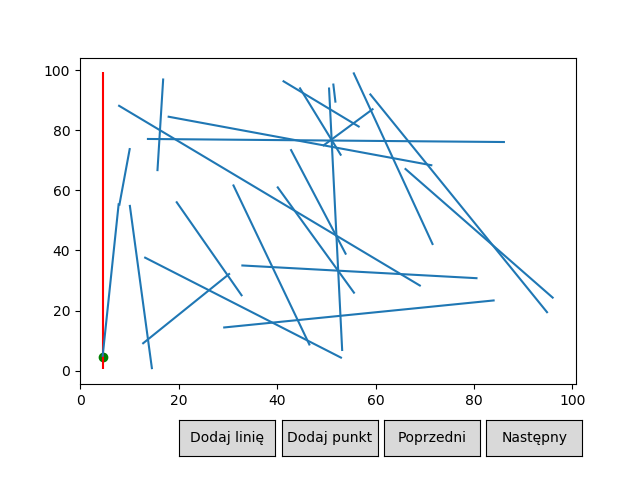

In [192]:
lines=generate_random_lines()
(worked,steps)=any_lines_intersects(lines)
steps.draw()

# Test dla dużej ilości linii np. 20

Enter the number of lines you want to generate randomly: 20
Enter first bound of x and y: 0
Enter second bound of x and y: 1000
The first detected intersection point is  (209.3478385025, 645.3725589103)


<IPython.core.display.Javascript object>


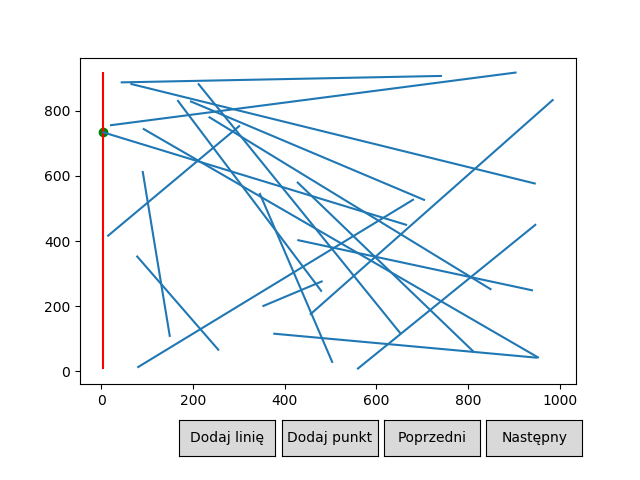

In [75]:
lines=generate_random_lines()
(worked,steps)=any_lines_intersects(lines)
steps.draw()

# Teraz testuje program dla interaktywnie wygenerowanych linii 
# Test dla linii, które nigdzie się nie przecinają

<IPython.core.display.Javascript object>


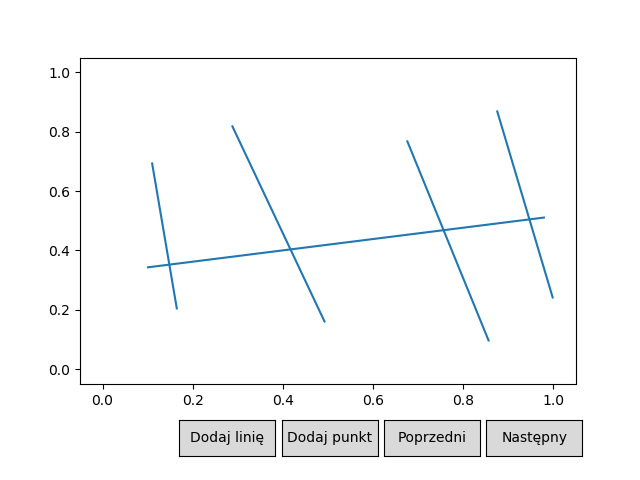

In [200]:
plot1=Plot()
plot1.draw()

In [201]:
tmp=generate_your_lines_from_scene(plot1)

The first detected intersection point is  (0.1481502697, 0.3523018581)


<IPython.core.display.Javascript object>


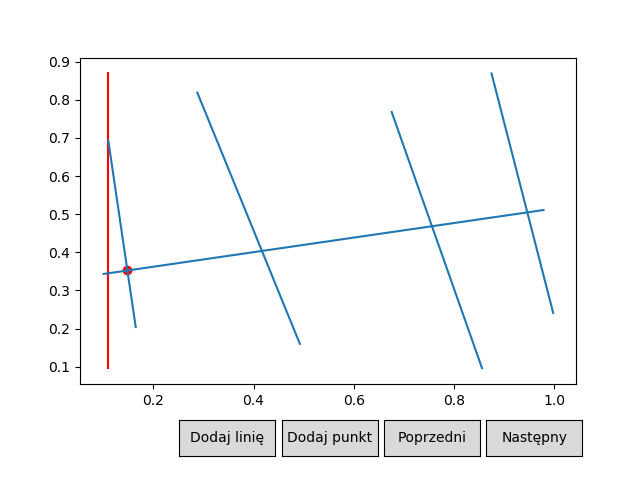

In [203]:
lines=copy(tmp)
(worked,steps)=any_lines_intersects(lines)
steps.draw()

# Test dla linii, które przecinają się pod koniec algorytmu

<IPython.core.display.Javascript object>


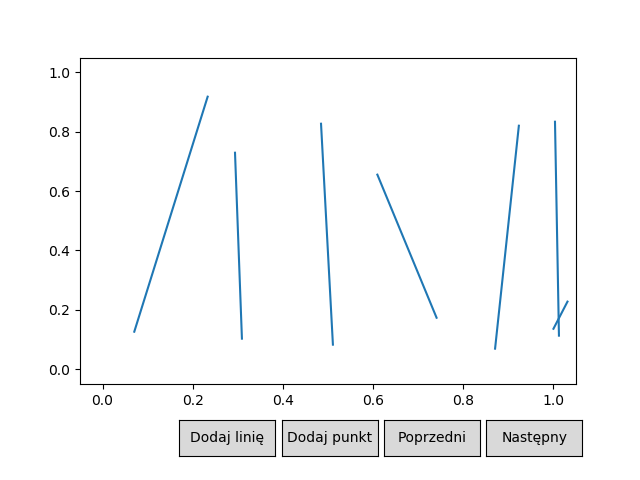

In [79]:
plot2=Plot()
plot2.draw()

In [205]:
tmp=generate_your_lines_from_scene(plot2)

The first detected intersection point is  (0.1481502697, 0.3523018581)


<IPython.core.display.Javascript object>


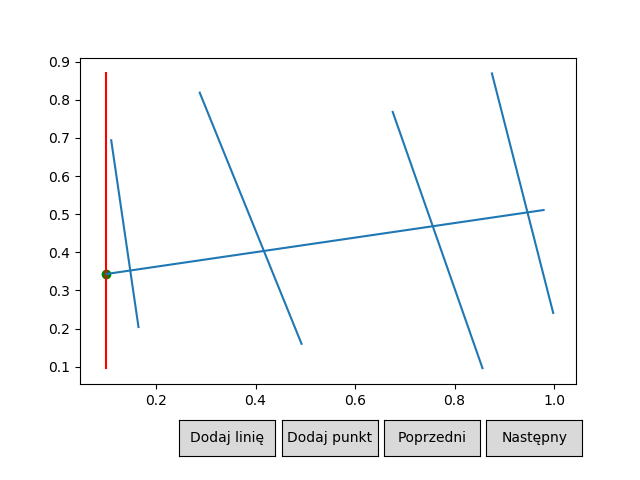

In [204]:
lines=copy(tmp)
(worked,steps)=any_lines_intersects(lines)
steps.draw()

# Test sprawdzający czy zapisywanie i wczytywanie danych z pliku działa

Enter the number of lines you want to generate randomly: 10
Enter first bound of x and y: 0
Enter second bound of x and y: 10
[{"points": [[]], "lines": [[[[3.0232192783, 9.1902485905], [8.2560735967, 9.1178435093]], [[4.7968180048, 9.641817774], [4.828583959, 8.9833866204]], [[0.7017699074, 5.7339751269], [4.871626928, 6.786748847]], [[4.0286567519, 9.4079834358], [7.2407993635, 4.1410866686]], [[3.9163272525, 2.6387491465], [9.3557094907, 9.8819995908]], [[0.4334522794, 8.6765057452], [8.6667775622, 0.746525381]], [[2.71471889, 9.5353289757], [3.6605208303, 9.9330166999]], [[2.2834986815, 3.539204086], [9.9193641318, 4.0435798092]], [[2.3260778336, 8.4281024341], [4.6597433322, 2.9558600696]], [[3.9792245414, 5.7208872092], [9.1902027463, 8.9203425284]]]]}]


<IPython.core.display.Javascript object>


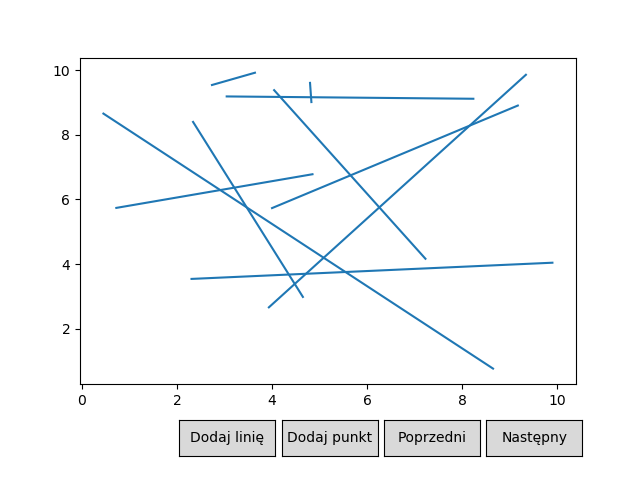

In [206]:
tmp=generate_random_lines()
scenex=[Scene([PointsCollection([])],[LinesCollection(drawLines(tmp))])]
plotx=Plot(scenex)
save_lines_to_file("test.txt",plotx)
lines_from_file=generate_lines_from_file("test.txt")
print(lines_from_file)
plot2x=Plot(json=lines_from_file)
plot2x.draw()

The first detected intersection point is  (2.9097619337, 6.2914321255)


<IPython.core.display.Javascript object>


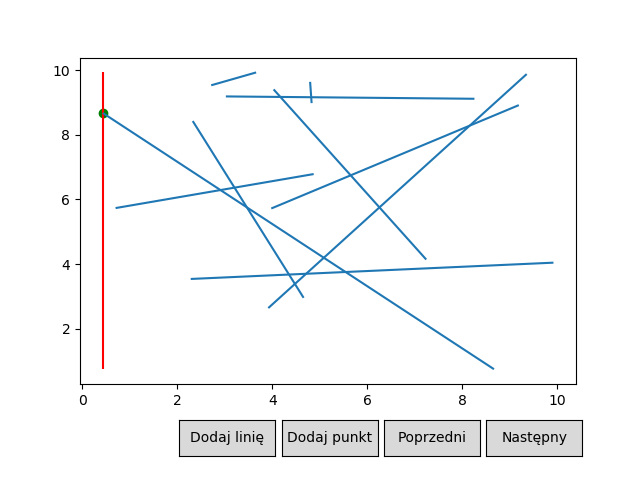

In [207]:
lines=copy(tmp)
(worked,steps)=any_lines_intersects(lines)
steps.draw()

# Rozwiązanie punktu 6 - modyfikacja algorytmu w celu znalezienia wszystkich punktów przecięć

# Dla potrzeby zmiany struktury zdarzeń wrzucam drugie drzewo, zmodyfikowane tak by trzymało punkty zdarzeń

In [195]:
# Written by Charles Oliver Nutter
# Modified for the purpose of Line Segments Intersection problem by Łukasz Jezapkowicz
from math import sqrt

class Node2:
    RED = True
    BLACK = False

    def __init__(self, point, color = RED):
        if not type(color) == bool:
            raise TypeError("Bad value for color parameter, expected True/False but given %s" % color)
        self.color = color
        self.point = point
        self.left = self.right = self.parent = NilNode2.instance()

    def __str__(self, level = 0, indent = "   "):
        s = level * indent + str(self.point)
        if self.left:
            s = s + "\n" + self.left.__str__(level + 1, indent)
        if self.right:
            s = s + "\n" + self.right.__str__(level + 1, indent)
        return s

    def __nonzero__(self):
        return True

    def __bool__(self):
        return True


class NilNode2(Node2):
    __instance__ = None

    @classmethod
    def instance(self):
        if self.__instance__ is None:
            self.__instance__ = NilNode2()
        return self.__instance__

    def __init__(self):
        self.color = Node2.BLACK
        self.point = None
        self.left = self.right = self.parent = None

    def __nonzero__(self):
        return False

    def __bool__(self):
        return False

class RedBlackTree2:
    def __init__(self):
        self.root = NilNode2.instance()
        self.size = 0

    def __str__(self):
        return ("(root.size = %d)\n" % self.size)  + str(self.root)

    def add(self, point):
        self.insert(Node2(point))

    def insert(self, x):
        self.__insert_helper(x)

        x.color = Node2.RED
        while x != self.root and x.parent.color == Node2.RED:
            if x.parent == x.parent.parent.left:
                y = x.parent.parent.right
                if y and y.color == Node2.RED:
                    x.parent.color = Node2.BLACK
                    y.color = Node2.BLACK
                    x.parent.parent.color = Node2.RED
                    x = x.parent.parent
                else:
                    if x == x.parent.right:
                        x = x.parent
                        self.__left_rotate(x)
                    x.parent.color = Node2.BLACK
                    x.parent.parent.color = Node2.RED
                    self.__right_rotate(x.parent.parent)
            else:
                y = x.parent.parent.left
                if y and y.color == Node2.RED:
                    x.parent.color = Node2.BLACK
                    y.color = Node2.BLACK
                    x.parent.parent.color = Node2.RED
                    x = x.parent.parent
                else:
                    if x == x.parent.left:
                        x = x.parent
                        self.__right_rotate(x)
                    x.parent.color = Node2.BLACK
                    x.parent.parent.color = Node2.RED
                    self.__left_rotate(x.parent.parent)
        self.root.color = Node2.BLACK

    def delete(self, point):
        z=self.search(point)
        if not z.left or not z.right:
            y = z
        else:
            y = self.successor(point)
        if not y.left:
            x = y.right
        else:
            x = y.left
        x.parent = y.parent

        if not y.parent:
            self.root = x
        else:
            if y == y.parent.left:
                y.parent.left = x
            else:
                y.parent.right = x

        if y != z: z.point = y.point

        if y.color == Node2.BLACK:
            self.__delete_fixup(x)

        self.size -= 1
        return y

    def successor(self, point):
        x=self.search(point)
        if x.right:
            return self.minimum(x.right)
        y = x.parent
        while y and x == y.right:
            x = y
            y = y.parent
        return y

    def predecessor(self, point):
        x=self.search(point)
        if x.left:
            return self.maximum(x.left)
        y = x.parent
        while y and x == y.left:
            x = y
            y = y.parent
        return y

    def minimum(self, x = None):
        if x is None: x = self.root
        while x.left:
            x = x.left
        return x

    def maximum(self, x = None):
        if x is None: x = self.root
        while x.right:
            x = x.right
        return x

    def search(self, point, x = None):
        if x is None: x = self.root
        while x:
            if x.point==point:
                return x
            elif x.point>point:
                x = x.left
            else:
                x = x.right
        return None
    
    def inorder_walk(self, x = None):
        if x is None: x = self.root
        x = self.minimum()
        while x:
            yield x.point
            x = self.successor(x.point)
            
    def reverse_inorder_walk(self, x = None):
        if x is None: x = self.root
        x = self.maximum()
        while x:
            yield x.point
            x = self.predecessor(x.point)

    def __left_rotate(self, x):
        if not x.right:
            raise "x.right is nil!"
        y = x.right
        x.right = y.left
        if y.left: y.left.parent = x
        y.parent = x.parent
        if not x.parent:
            self.root = y
        else:
            if x == x.parent.left:
                x.parent.left = y
            else:
                x.parent.right = y
        y.left = x
        x.parent = y

    def __right_rotate(self, x):
        if not x.left:
            raise "x.left is nil!"
        y = x.left
        x.left = y.right
        if y.right: y.right.parent = x
        y.parent = x.parent
        if not x.parent:
            self.root = y
        else:
            if x == x.parent.left:
                x.parent.left = y
            else:
                x.parent.right = y
        y.right = x
        x.parent = y

    def __insert_helper(self, z):
        y = NilNode2.instance()
        x = self.root
        while x:
            y = x
            if x.point>z.point:
                x = x.left
            else:
                x = x.right
        z.parent = y
        if not y:
            self.root = z
        else:
            if y.point>z.point:
                y.left = z
            else:
                y.right = z

        self.size += 1

    def __delete_fixup(self, x):
        while x != self.root and x.color == Node2.BLACK:
            if x == x.parent.left:
                w = x.parent.right
                if w.color == Node2.RED:
                    w.color = Node2.BLACK
                    x.parent.color = Node2.RED
                    self.__left_rotate(x.parent)
                    w = x.parent.right
                if w.left.color == Node2.BLACK and w.right.color == Node2.BLACK:
                    w.color = Node2.RED
                    x = x.parent
                else:
                    if w.right.color == Node2.BLACK:
                        w.left.color = Node2.BLACK
                        w.color = Node2.RED
                        self.__right_rotate(w)
                        w = x.parent.right
                    w.color = x.parent.color
                    x.parent.color = Node2.BLACK
                    w.right.color = Node2.BLACK
                    self.__left_rotate(x.parent)
                    x = self.root
            else:
                w = x.parent.left
                if w.color == Node2.RED:
                    w.color = Node2.BLACK
                    x.parent.color = Node2.RED
                    self.__right_rotate(x.parent)
                    w = x.parent.left
                if w.right.color == Node2.BLACK and w.left.color == Node2.BLACK:
                    w.color = Node2.RED
                    x = x.parent
                else:
                    if w.left.color == Node2.BLACK:
                        w.right.color = Node2.BLACK
                        w.color = Node2.RED
                        self.__left_rotate(w)
                        w = x.parent.left
                    w.color = x.parent.color
                    x.parent.color = Node2.BLACK
                    w.left.color = Node2.BLACK
                    self.__right_rotate(x.parent)
                    x = self.root
        x.color = Node2.BLACK

In [196]:
def look_intersection2(p,line1,line2,P,Q,steps,lines,min_y,max_y,duplicates):
    intersection=intersect(line1,line2)
    if not intersection is None and intersection in P:
        duplicates.append(intersection)
    if not intersection is None and intersection not in P:
        steps.add_scene(Scene([PointsCollection([intersection],color='red')],[LinesCollection([[(p[0].x,min_y),(p[0].x,max_y)]],color='red'),
                                                          LinesCollection(drawLines(lines))]))
        Q.add((Point(intersection[0],intersection[1]),0,line1,line2))
        P.add(intersection)
        print(line1, " and ", line2, " intersect at the point ", intersection, "\n")

def every_lines_intersections(lines):         #TODO: color lines which are in T
    T=RedBlackTree()                          # T is a RB-Tree, all operations in O(logn)
    Q=RedBlackTree2()                         # Q is also a RB-Tree, but containing points
    P=set()                                   # P is a set
    steps=[]
    duplicates=[]
    steps = Plot(steps)
    min_y=min(min(line.s.y for line in lines),min(line.e.y for line in lines))
    max_y=max(max(line.s.y for line in lines),max(line.e.y for line in lines))
    for line in lines:
        Q.add((line.s,-1,line,None))   # start point of line symbolized by -1
        Q.add((line.e,1,line,None))    # end point of line symbolized by 1
    while Q.size>0:
        p = Q.minimum().point
        Q.delete(p)
        steps.add_scene(Scene([PointsCollection([(p[0].x,p[0].y)],color='green')],
                              [LinesCollection([[(p[0].x,min_y),(p[0].x,max_y)]],color='red'),LinesCollection(drawLines(lines))]))
        if p[1]==-1:
            T.add(p[2])
            prd=T.predecessor(p[2])
            suc=T.successor(p[2])
            if prd:
                look_intersection2(p,p[2],prd.line,P,Q,steps,lines,min_y,max_y,duplicates)
            if suc:
                look_intersection2(p,p[2],suc.line,P,Q,steps,lines,min_y,max_y,duplicates)
        elif p[1]==1:
            prd=T.predecessor(p[2])
            suc=T.successor(p[2])
            if prd and suc:
                look_intersection2(p,prd.line,suc.line,P,Q,steps,lines,min_y,max_y,duplicates)
            T.delete(p[2])
        elif p[1]==0:
            T.delete(p[2])
            T.delete(p[3])
            p[2].orientation=Point(p[0].x,p[0].y)
            p[3].orientation=Point(p[0].x,p[0].y)
            T.add(p[2])
            T.add(p[3])
            upper1=p[2]
            lower1=p[2]
            prd=T.predecessor(upper1)
            suc=T.successor(lower1)
            if prd:
                look_intersection2(p,upper1,prd.line,P,Q,steps,lines,min_y,max_y,duplicates)
            if suc:
                look_intersection2(p,lower1,suc.line,P,Q,steps,lines,min_y,max_y,duplicates)
            upper2=p[3]
            lower2=p[3]
            prd2=T.predecessor(upper2)
            suc2=T.successor(lower2)
            if prd2:
                look_intersection2(p,upper2,prd2.line,P,Q,steps,lines,min_y,max_y,duplicates)
            if suc2:
                look_intersection2(p,lower2,suc2.line,P,Q,steps,lines,min_y,max_y,duplicates)
    points=[]
    for p in P:
        points.append((p[0],p[1]))
    
    print("There are " + str(len(points)) + " intersecting points ")
    if(len(points)!=0):
        print("How many times were each point averagely found?", str((len(duplicates)+len(points))/len(points)))
    steps.add_scene(Scene([PointsCollection(points,color='red')],[LinesCollection(drawLines(lines))]))
    return steps,P

# KONTYNUACJA W DOMU 
# Zmiany w kodzie powyżej obejmują: 
# - dodanie klasy Point 
# - mała modyfikacja klasy Line
# - dokończenie algorytmu every_lines_intersections()
# - małe zmiany w drzewach
# - modyfikacja generowania linii tak by żadne końce się nie stykały

# Rozwiązanie punktu 7 znajduje się w pliku tekstowym "Punkt7.pdf"

# Rozwiązanie punktu 8 - sprawdzenie działaniu algorytmu every_lines_intersections()

# Teraz testuje program dla losowo wygenerowanych linii z danego przedziału 
#  Dla leniwych : kliknięcie "poprzedni" pokazuje wszystkie punkty przecięcia 
# Test dla małej ilości linii np. 5

Enter the number of lines you want to generate randomly: 13
Enter first bound of x and y: 0
Enter second bound of x and y: 100
Line segment from (6.4217891924,18.3085443904) to (23.3002031732,39.6839885447)  and  Line segment from (6.3150219792,34.2570065961) to (56.5638823323,50.1403238414)  intersect at the point  (23.2390846112, 39.6065857502) 

Line segment from (29.4544710823,17.1455423491) to (95.8896046954,87.5463126221)  and  Line segment from (12.3379224184,14.3227663498) to (59.2111926911,44.0985724123)  intersect at the point  (48.4209643988, 37.2441809194) 

Line segment from (30.2102684374,9.0962763638) to (65.1700767675,67.4801221771)  and  Line segment from (29.4544710823,17.1455423491) to (95.8896046954,87.5463126221)  intersect at the point  (44.710775753, 33.3125242143) 

Line segment from (32.1243583403,32.8300192802) to (34.614774109,76.0732303191)  and  Line segment from (6.3150219792,34.2570065961) to (56.5638823323,50.1403238414)  intersect at the point  (32.6866

<IPython.core.display.Javascript object>


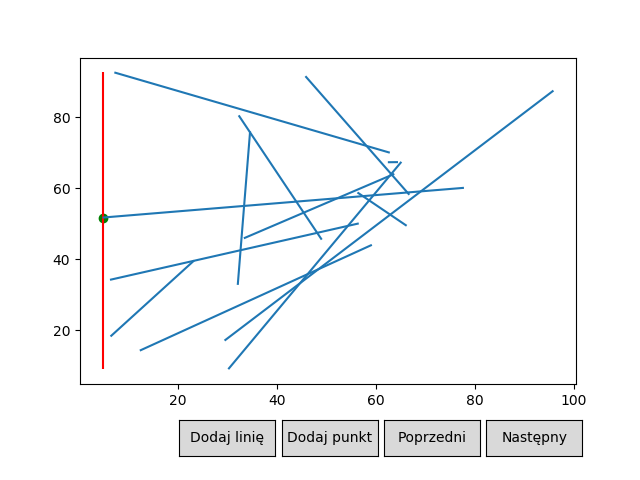

In [197]:
lines=generate_random_lines()
(steps,P)=every_lines_intersections(lines)
steps.draw()

# Test dla dużej ilości linii np. 20

Enter the number of lines you want to generate randomly: 100
Enter first bound of x and y: 0
Enter second bound of x and y: 1
Line segment from (0.0238757314,0.9756682307) to (0.7781909022,0.0505173473)  and  Line segment from (0.0070380743,0.3239005944) to (0.3749663155,0.8966950974)  intersect at the point  (0.2486295249, 0.700012671) 

Line segment from (0.0265529802,0.6294323879) to (0.809215667,0.5380571324)  and  Line segment from (0.0238757314,0.9756682307) to (0.7781909022,0.0505173473)  intersect at the point  (0.3355945169, 0.5933520306) 

Line segment from (0.0265529802,0.6294323879) to (0.809215667,0.5380571324)  and  Line segment from (0.0070380743,0.3239005944) to (0.3749663155,0.8966950974)  intersect at the point  (0.19096349, 0.6102375897) 

Line segment from (0.0317253656,0.6929486012) to (0.8164252619,0.4367763117)  and  Line segment from (0.0238757314,0.9756682307) to (0.7781909022,0.0505173473)  intersect at the point  (0.3351547792, 0.5938913591) 

Line segment fr

Line segment from (0.0265529802,0.6294323879) to (0.809215667,0.5380571324)  and  Line segment from (0.3485622891,0.6418088879) to (0.9895820823,0.151106754)  intersect at the point  (0.4255882561, 0.5828453321) 

Line segment from (0.3479320253,0.2462119863) to (0.4449835725,0.5714000341)  and  Line segment from (0.1878458625,0.5755559698) to (0.554346929,0.1076291535)  intersect at the point  (0.3749353288, 0.3366912398) 

Line segment from (0.3433996126,0.066046917) to (0.6845086829,0.8999101584)  and  Line segment from (0.3120700688,0.1868599669) to (0.5603755201,0.246686348)  intersect at the point  (0.4016497589, 0.2084431768) 

Line segment from (0.3162338681,0.1064938286) to (0.5381342449,0.1766843109)  and  Line segment from (0.3636727516,0.0831775569) to (0.7190398741,0.3281074084)  intersect at the point  (0.4664358392, 0.1540050088) 

Line segment from (0.174648182,0.7050945553) to (0.819955681,0.0013236297)  and  Line segment from (0.1275859766,0.291128819) to (0.807636157

Line segment from (0.3433996126,0.066046917) to (0.6845086829,0.8999101584)  and  Line segment from (0.053933634,0.6317901753) to (0.7839589596,0.3127515117)  intersect at the point  (0.4958292812, 0.4386711261) 

Line segment from (0.1275859766,0.291128819) to (0.807636157,0.8206433521)  and  Line segment from (0.4252783734,0.6363428762) to (0.9442138508,0.4986350071)  intersect at the point  (0.533916337, 0.6075140466) 

Line segment from (0.0265529802,0.6294323879) to (0.809215667,0.5380571324)  and  Line segment from (0.4567724556,0.517377681) to (0.8159537396,0.8939411059)  intersect at the point  (0.50983626, 0.5730094436) 

Line segment from (0.4778904557,0.0655564437) to (0.5841357221,0.7400711163)  and  Line segment from (0.3636727516,0.0831775569) to (0.7190398741,0.3281074084)  intersect at the point  (0.4949139913, 0.1736330192) 

Line segment from (0.4696186646,0.1846892878) to (0.8160117031,0.0076477318)  and  Line segment from (0.4778904557,0.0655564437) to (0.5841357221

Line segment from (0.5069961917,0.2750736532) to (0.8257878646,0.7279693751)  and  Line segment from (0.0317253656,0.6929486012) to (0.8164252619,0.4367763117)  intersect at the point  (0.657368326, 0.488701869) 

Line segment from (0.6155875077,0.5721337158) to (0.6837199953,0.7749464207)  and  Line segment from (0.0858098856,0.9551322269) to (0.9067016093,0.4525913171)  intersect at the point  (0.6319362457, 0.6207996591) 

Line segment from (0.575229645,0.7966214477) to (0.8285883394,0.1943079296)  and  Line segment from (0.1275859766,0.291128819) to (0.807636157,0.8206433521)  intersect at the point  (0.6249575891, 0.678402442) 

Line segment from (0.3485622891,0.6418088879) to (0.9895820823,0.151106754)  and  Line segment from (0.053933634,0.6317901753) to (0.7839589596,0.3127515117)  intersect at the point  (0.7710516138, 0.3183923329) 

Line segment from (0.487047266,0.3103756336) to (0.710198474,0.9166971309)  and  Line segment from (0.575229645,0.7966214477) to (0.8285883394,0


Line segment from (0.7349118527,0.1179120459) to (0.8830053833,0.5602464484)  and  Line segment from (0.575229645,0.7966214477) to (0.8285883394,0.1943079296)  intersect at the point  (0.7906696356, 0.2844526469) 

Line segment from (0.7694859716,0.1785099951) to (0.8124352265,0.3557739235)  and  Line segment from (0.3731787799,0.5353437642) to (0.8141484865,0.2607830152)  intersect at the point  (0.7926613695, 0.2741615282) 

Line segment from (0.7349118527,0.1179120459) to (0.8830053833,0.5602464484)  and  Line segment from (0.2011283936,0.5229144653) to (0.9165195131,0.2404504479)  intersect at the point  (0.7923516871, 0.2894766966) 

Line segment from (0.575229645,0.7966214477) to (0.8285883394,0.1943079296)  and  Line segment from (0.3731787799,0.5353437642) to (0.8141484865,0.2607830152)  intersect at the point  (0.7958278275, 0.272189998) 

Line segment from (0.7349118527,0.1179120459) to (0.8830053833,0.5602464484)  and  Line segment from (0.3485622891,0.6418088879) to (0.989

<IPython.core.display.Javascript object>


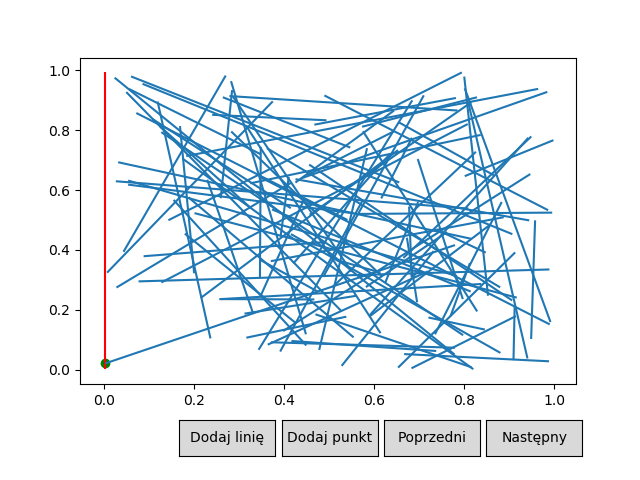

In [181]:
lines=generate_random_lines()
(steps,P)=every_lines_intersections(lines)
steps.draw()

# Teraz testuje program dla interaktywnie wygenerowanych linii 
# Test dla linii, które nigdzie się nie przecinają

<IPython.core.display.Javascript object>


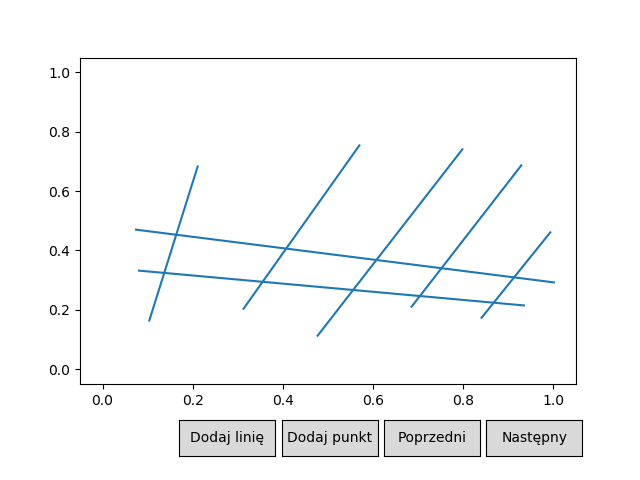

In [208]:
plot3=Plot()
plot3.draw()

In [209]:
tmp=generate_your_lines_from_scene(plot3)

Line segment from (0.1029548891,0.1605258119) to (0.211624244,0.686261106)  and  Line segment from (0.0785597278,0.3324008119) to (0.9368258569,0.2144473805)  intersect at the point  (0.1368262206, 0.3243931176) 

Line segment from (0.1029548891,0.1605258119) to (0.211624244,0.686261106)  and  Line segment from (0.071906502,0.4705748315) to (1.0033581149,0.2919596354)  intersect at the point  (0.1634148508, 0.4530271871) 

Line segment from (0.311422631,0.2009669884) to (0.5708984375,0.7570331648)  and  Line segment from (0.0785597278,0.3324008119) to (0.9368258569,0.2144473805)  intersect at the point  (0.3550237312, 0.2944057463) 

Line segment from (0.311422631,0.2009669884) to (0.5708984375,0.7570331648)  and  Line segment from (0.071906502,0.4705748315) to (1.0033581149,0.2919596354)  intersect at the point  (0.4072246413, 0.4062742126) 

Line segment from (0.4755355343,0.1099743413) to (0.7993258569,0.7435527727)  and  Line segment from (0.0785597278,0.3324008119) to (0.936825856

<IPython.core.display.Javascript object>


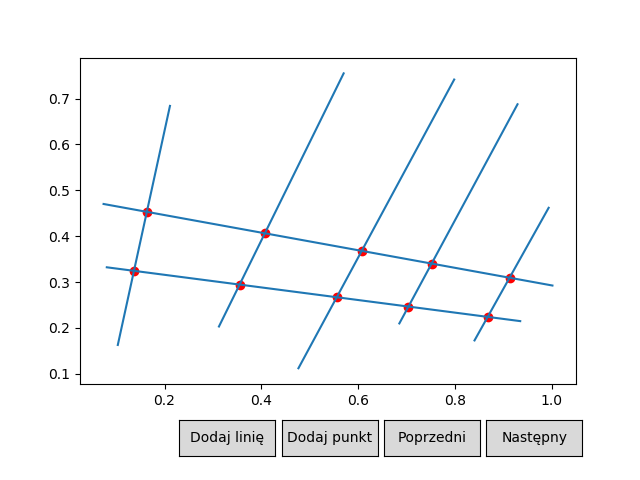

In [211]:
lines=copy(tmp)
(steps,P)=every_lines_intersections(lines)
steps.draw()

<IPython.core.display.Javascript object>


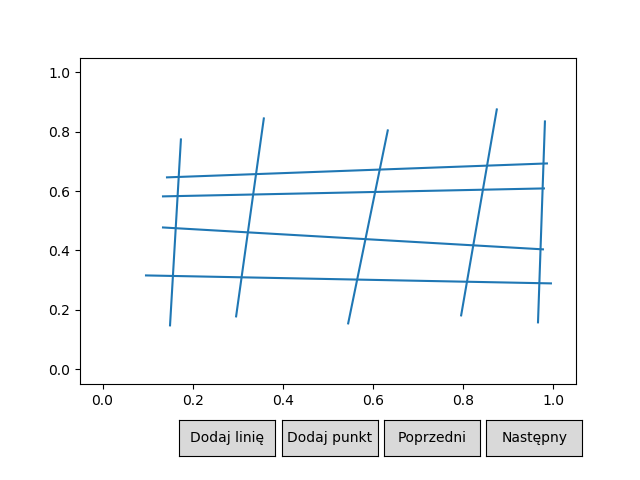

In [212]:
plot4=Plot()
plot4.draw()

In [213]:
tmp=generate_your_lines_from_scene(plot4)

# Test dla linii, które przecinają się w bardzo wielu miejscach 

Line segment from (0.1495274698,0.1440965839) to (0.173922631,0.7776750153)  and  Line segment from (0.0940839214,0.3159715839) to (0.9967048891,0.2890107996)  intersect at the point  (0.1560740121, 0.3141199745) 

Line segment from (0.1495274698,0.1440965839) to (0.173922631,0.7776750153)  and  Line segment from (0.1317855343,0.4777362898) to (0.9789629536,0.403594133)  intersect at the point  (0.1622711299, 0.4750682916) 

Line segment from (0.1495274698,0.1440965839) to (0.173922631,0.7776750153)  and  Line segment from (0.1317855343,0.582209329) to (0.9811806956,0.6091701134)  intersect at the point  (0.1664388159, 0.5833092642) 

Line segment from (0.1495274698,0.1440965839) to (0.173922631,0.7776750153)  and  Line segment from (0.140656502,0.6462411918) to (0.9878339214,0.6934225643)  intersect at the point  (0.1689225455, 0.6478153966) 

Line segment from (0.2958984375,0.1744274663) to (0.3579952117,0.8484470741)  and  Line segment from (0.0940839214,0.3159715839) to (0.99670488

<IPython.core.display.Javascript object>


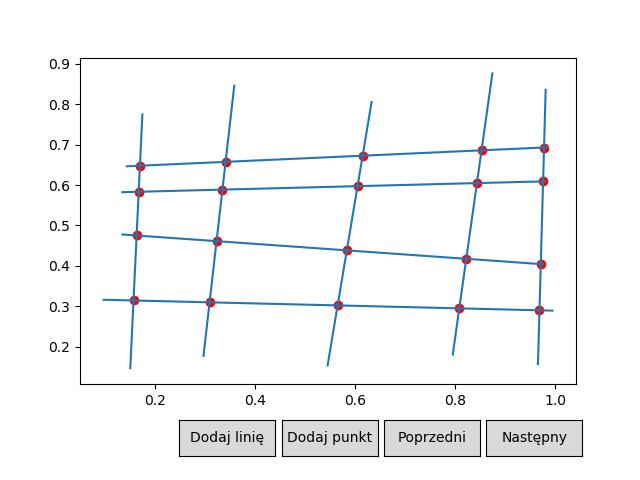

In [214]:
lines=copy(tmp)
(steps,P)=every_lines_intersections(lines)
steps.draw()

# Test sprawdzający czy zapisywanie i wczytywanie danych z pliku działa

Enter the number of lines you want to generate randomly: 10
Enter first bound of x and y: 0
Enter second bound of x and y: 10
[{"points": [[]], "lines": [[[[6.2562682507, 5.6239037233], [7.558255464, 2.485081516]], [[1.867315266, 8.9969854024], [6.673792441, 5.8435312812]], [[7.8920319005, 1.7378413361], [8.3152227578, 0.2036089244]], [[0.2565767178, 9.9453195129], [7.6705927726, 3.8473757056]], [[1.1281847139, 0.4022375484], [2.8305167245, 9.3958910096]], [[7.6441572261, 6.5071245059], [9.5382255641, 1.4771078486]], [[4.735295663, 5.2498339199], [5.6653378763, 3.2838778059]], [[2.3260287359, 4.6398444136], [3.409078325, 7.1923572153]], [[1.0864032291, 3.4364493193], [8.7516617756, 5.0966708124]], [[4.7005495124, 0.0437714533], [8.5859326078, 3.9956942524]]]]}]


<IPython.core.display.Javascript object>


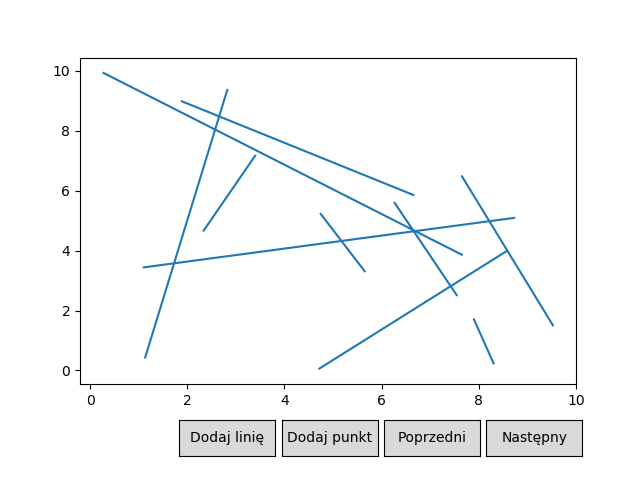

In [216]:
tmp=generate_random_lines()
scenex=[Scene([PointsCollection([])],[LinesCollection(drawLines(tmp))])]
plotx=Plot(scenex)
save_lines_to_file("test.txt",plotx)
lines_from_file=generate_lines_from_file("test.txt")
print(lines_from_file)
plot2x=Plot(json=lines_from_file)
plot2x.draw()

Line segment from (1.0864032291,3.4364493193) to (8.7516617756,5.0966708124)  and  Line segment from (0.2565767178,9.9453195129) to (7.6705927726,3.8473757056)  intersect at the point  (6.6936257644, 4.6509199485) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (1.0864032291,3.4364493193) to (8.7516617756,5.0966708124)  intersect at the point  (1.7288425989, 3.5755955259) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (0.2565767178,9.9453195129) to (7.6705927726,3.8473757056)  intersect at the point  (2.5737686178, 8.039455553) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (1.867315266,8.9969854024) to (6.673792441,5.8435312812)  intersect at the point  (2.6569507179, 8.4789179947) 

Line segment from (4.735295663,5.2498339199) to (5.6653378763,3.2838778059)  and  Line segment from (1.0864032291,3.4364493193) to (8.75166

<IPython.core.display.Javascript object>


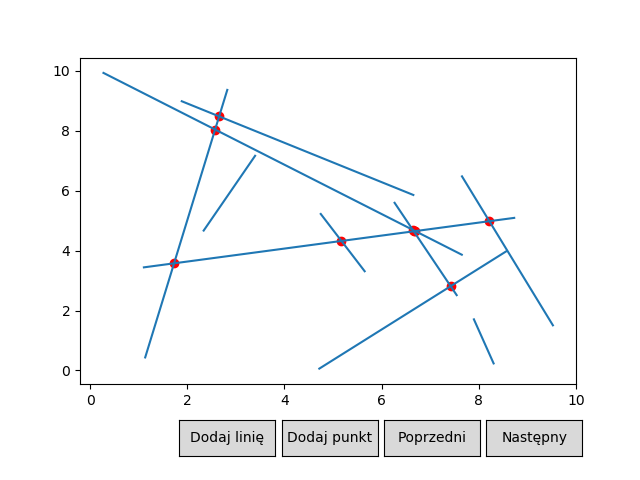

In [218]:
lines=copy(tmp)
(steps,P)=every_lines_intersections(lines)
steps.draw()

# Rozwiązanie punktu 9 znajduje się w pliku tekstowym "Punkt9.pdf" 

# Przykład zbioru linii, w którym punkty przecięcia znajdywane są wiele razy 
# (Proszę narysować cokolwiek, ważne żeby istniały punkty przecięcia)

<IPython.core.display.Javascript object>


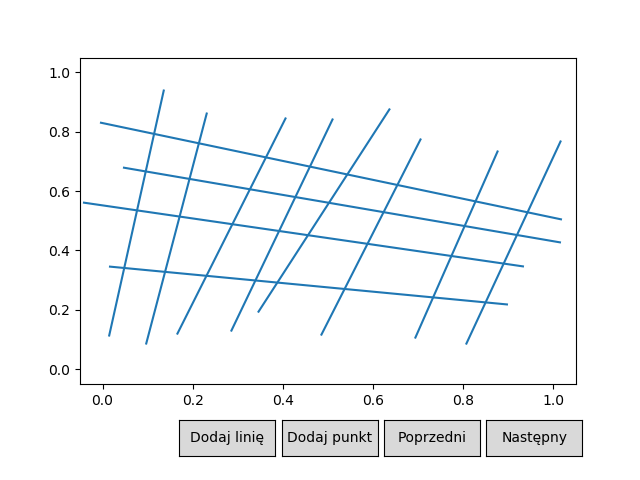

In [153]:
plot5=Plot()
plot5.draw()

In [ ]:
tmp=generate_your_lines_from_scene(plot5)

Line segment from (1.0864032291,3.4364493193) to (8.7516617756,5.0966708124)  and  Line segment from (0.2565767178,9.9453195129) to (7.6705927726,3.8473757056)  intersect at the point  (6.6936257644, 4.6509199485) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (1.0864032291,3.4364493193) to (8.7516617756,5.0966708124)  intersect at the point  (1.7288425989, 3.5755955259) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (0.2565767178,9.9453195129) to (7.6705927726,3.8473757056)  intersect at the point  (2.5737686178, 8.039455553) 

Line segment from (1.1281847139,0.4022375484) to (2.8305167245,9.3958910096)  and  Line segment from (1.867315266,8.9969854024) to (6.673792441,5.8435312812)  intersect at the point  (2.6569507179, 8.4789179947) 

Line segment from (4.735295663,5.2498339199) to (5.6653378763,3.2838778059)  and  Line segment from (1.0864032291,3.4364493193) to (8.75166

<IPython.core.display.Javascript object>


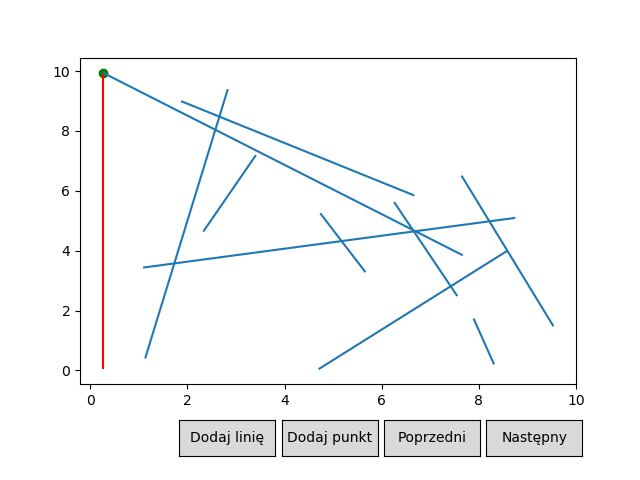

In [219]:
lines=copy(tmp)
(steps,P)=every_lines_intersections(lines)
steps.draw()